SETUP

In [ ]:
!pip install datasets
!pip install sentencepiece
!pip install transformers
!pip install rouge_score
!pip install bert_score 

from bert_score import score
from datasets import load_dataset, Dataset, load_metric
import sys
from google.colab import drive
import pandas as pd
import numpy as np
from transformers import BartForConditionalGeneration, BartTokenizer, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import torch
import huggingface_hub
import matplotlib.pyplot as plt
import nltk
nltk.download("punkt")
import gc
from torch import nn 


In [ ]:

gpu_info = !nvidia-smi -L
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU")
else:
    print(gpu_info)



drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/CS_SOP/')


from tweet_sum_processor import TweetSumProcessor


torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'




model_name = "facebook/bart-large"
model = BartForConditionalGeneration.from_pretrained(model_name)
tokenizer = BartTokenizer.from_pretrained(model_name)

# ----- Metric
metric = load_metric("rouge")

# ---- Freeze parameters

def freeze_params(model: nn.Module):
    """Set requires_grad=False for each of model.parameters()"""
    for par in model.parameters():
        par.requires_grad = False

def freeze_embeds(model):
    """Freeze token embeddings and positional embeddings for BART and PEGASUS, just token embeddings for t5."""
    model_type = model.config.model_type
    if model_type == "t5":
        freeze_params(model.shared)
        for d in [model.encoder, model.decoder]:
            freeze_params(d.embed_tokens)
    else:
        freeze_params(model.model.shared)
        for d in [model.model.encoder, model.model.decoder]:
            freeze_params(d.embed_positions)
            freeze_params(d.embed_tokens)

freeze_embeds(model)

# ----- Reading in the Dataset
raw_datasets = load_dataset('csv', data_files={'train': '/content/drive/MyDrive/CS_SOP/tweetsum_train.csv',
                                          'valid': '/content/drive/MyDrive/CS_SOP/tweetsum_valid.csv',
                                          'test': '/content/drive/MyDrive/CS_SOP/tweetsum_test.csv'})

GPU 0: Tesla K80 (UUID: GPU-073367d5-dd0a-e624-cc27-59cb56a2347f)
Mounted at /content/drive


Downloading:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/971M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Using custom data configuration default-c28ca8dc4ee9fbdc


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c28ca8dc4ee9fbdc/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
max_input_length = 512
max_target_length = 128

def preprocess_function(examples):
    model_inputs = tokenizer(examples["inputs"], max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summaries"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
print(tokenized_datasets["test"]['inputs'])

['hulusupport My watchlist is not updating with new episodes past couple days. Any idea why? <BR> Apologies for the trouble, Norlene! Were looking into this. In the meantime, try navigating to the season episode manually. <BR> hulusupport Tried logging outback in, that didnt help <BR> Sorry! We assure you that our team is working hard to investigate, and we hope to have a fix ready soon! <BR> hulusupport Thank you! Some shows updated overnight, but others did not. <BR> We definitely understand, Norlene. For now, we recommend checking the show page for these shows as the new eps will be there <BR> hulusupport As of this morning, the problem seems to be resolved. Watchlist updated overnight with all new episodes. Thank you for your attention to this matter! I love Hulu <BR> Awesome! Thats what we love to hear. If you happen to need anything else, well be here to support! <BR>', 'AirbnbHelp hi , my Acc was linked to an old number. Now Im asked to verify my Acc , where a code call wil be s

In [ ]:
batch_size = 1
args = Seq2SeqTrainingArguments(
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
    output_dir = '/content/drive/MyDrive/CS_SOP/results/bart', 
    logging_dir = '/content/drive/MyDrive/CS_SOP/logs/bart'
)

In [ ]:


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: inputs, summaries. If inputs, summaries are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 869
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 2607


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.377300,1.981778,34.148100,15.243500,29.336300,32.192100,20.000000
2,1.657700,1.897160,34.396200,15.946600,29.967800,32.668600,20.000000
3,1.393900,1.900038,34.840500,16.300200,30.640200,33.023500,20.000000


Saving model checkpoint to /content/drive/MyDrive/CS_SOP/results/bart/checkpoint-500
Configuration saved in /content/drive/MyDrive/CS_SOP/results/bart/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/CS_SOP/results/bart/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/CS_SOP/results/bart/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/CS_SOP/results/bart/checkpoint-500/special_tokens_map.json
Deleting older checkpoint [/content/drive/MyDrive/CS_SOP/results/bart/checkpoint-1500] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: inputs, summaries. If inputs, summaries are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 108
  Batch size = 1
Saving model checkpoint to /conte

TrainOutput(global_step=2607, training_loss=1.75626813729787, metrics={'train_runtime': 3953.8935, 'train_samples_per_second': 0.659, 'train_steps_per_second': 0.659, 'total_flos': 1490781730701312.0, 'train_loss': 1.75626813729787, 'epoch': 3.0})

# TESTING

In [ ]:

out = trainer.predict(tokenized_datasets["test"])
generated_summaries = []
for i in range(0, 110): 
  generated_summaries.append(tokenizer.decode(out[0][i], skip_special_tokens =  True))
ground_truth = tokenized_datasets["test"]["summaries"]
conversation = tokenized_datasets["test"]["inputs"]


The following columns in the test set  don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: inputs, summaries. If inputs, summaries are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 110
  Batch size = 1


## ROUGE SCORES 

In [ ]:
out.metrics

{'test_gen_len': 20.0,
 'test_loss': 1.952686071395874,
 'test_rouge1': 33.9861,
 'test_rouge2': 15.1397,
 'test_rougeL': 30.4782,
 'test_rougeLsum': 32.0281,
 'test_runtime': 182.6928,
 'test_samples_per_second': 0.602,
 'test_steps_per_second': 0.602}

## BART-SCORE

In [ ]:
P, R, F1 = score(generated_summaries, ground_truth, lang="en", verbose=True)

Could not locate the tokenizer configuration file, will try to use the model config instead.
https://huggingface.co/roberta-large/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpv4p2cghz


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373
creating metadata file for /root/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373
loading configuration file https://huggingface.co/roberta-large/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373
Model config RobertaConfig {
  "_name_or_path": "roberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/7c1ba2435b05451bc3b4da073c8dec9630b22024a65f6c41053caccf2880eb8f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
creating metadata file for /root/.cache/huggingface/transformers/7c1ba2435b05451bc3b4da073c8dec9630b22024a65f6c41053caccf2880eb8f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
https://huggingface.co/roberta-large/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpg1k917lb


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/20b5a00a80e27ae9accbe25672aba42ad2d4d4cb2c4b9359b50ca8e34e107d6d.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/20b5a00a80e27ae9accbe25672aba42ad2d4d4cb2c4b9359b50ca8e34e107d6d.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-large/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/7c1ba2435b05451bc3b4da073c8dec9630b22024a65f6c41053caccf2880eb8f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-large/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/20b5a00a80e27ae9accbe25672aba42ad2d4d4cb2c4b9359b50ca8e34e107d6d.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/8e36ec2f5052bec1e79e139b84c2c3089cb647694ba0f4f634fec7b8258f7c89.c43841d8c5cd23c435408295164cda9525270aa42cd0cc9200911570c0342352
creating metadata file for /root/.cache/huggingface/transformers/8e36ec2f5052bec1e79e139b84c2c3089cb647694ba0f4f634fec7b8258f7c89.c43841d8c5cd23c435408295164cda9525270aa42cd0cc9200911570c0342352
loading weights file https://huggingface.co/roberta-large/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/8e36ec2f5052bec1e79e139b84c2c3089cb647694ba0f4f634fec7b8258f7c89.c43841d8c5cd23c435408295164cda9525270aa42cd0cc9200911570c0342352
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are ini

calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 3.72 seconds, 29.54 sentences/sec


### SCORES

In [ ]:
print(f"System level F1 score: {F1.mean():.3f}")
print(f"System level precision score: {P.mean():.3f}")
print(f"System level recall score: {R.mean():.3f}")

System level F1 score: 0.884
System level precision score: 0.901
System level recall score: 0.868


### VISUALIZATIONS

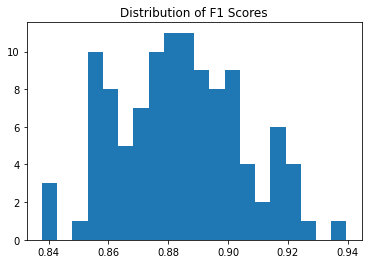

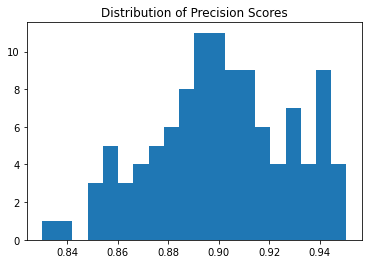

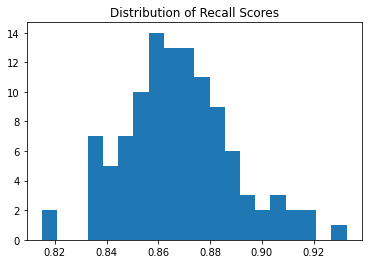

In [ ]:
plt.hist(F1, bins=20)
plt.title("Distribution of F1 Scores")
plt.show()

plt.hist(P, bins=20)
plt.title("Distribution of Precision Scores")
plt.show()

plt.hist(R, bins=20)
plt.title("Distribution of Recall Scores")
plt.show()

## SAVE SUMMARIES TO CSV 

In [ ]:
# ----- Mounting Google Drive ----- # 

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/CS_SOP')
bart_summaries = pd.DataFrame({"candidate": generated_summaries, "reference": ground_truth, "conversation": conversation})
bart_summaries.to_csv('/content/drive/MyDrive/CS_SOP/summaries/') 
print("Done")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IsADirectoryError: ignored

In [ ]:
%cd drive/MyDrive/CS_SOP

In [ ]:
!ls

In [ ]:
%cd results/bart/checkpoint-2500

In [ ]:
OUTPUT_DIR = "/content/drive/MyDrive/CS_SOP/results/bart/checkpoint-2500"
model = BartForConditionalGeneration.from_pretrained(OUTPUT_DIR)
BATCH_SIZE = 1
# arguments for Trainer
test_args = Seq2SeqTrainingArguments(
    output_dir = OUTPUT_DIR,
    do_train = False,
    do_predict = True,
    per_device_eval_batch_size = BATCH_SIZE,   
    dataloader_drop_last = False    
)

# init trainer
trainer = Seq2SeqTrainer(
              model = model, 
              args = test_args, 
              compute_metrics = compute_metrics)

# test_results = trainer.predict(test_dataset)

In [ ]:
 tokenizer = BartTokenizer.from_pretrained(OUTPUT_DIR)
 temp = {"inputs" : ["Hello", "My name is Pranav"]}
 model_inputs =tokenizer(temp["inputs"], max_length=max_input_length, truncation=True)

FineTuned Model On SamSum Dataset

In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization", model="philschmid/bart-large-cnn-samsum")



In [ ]:
conversation = '''
: MOHAMMED SALMAN. Question: IN NEED RESIDENCY MY ADDRESS? [] : Support. Question: IN NEED RESIDENCY MY ADDRESS? [] Support:Good morning .How may i assist you? MOHAMMED SALMAN:GOOD MORNING Support:May I know your registered mobile number? MOHAMMED SALMAN:I NEED MY RESIDENCY ADDRESS MOHAMMED SALMAN:7022298560 Support:Details not fund. Support:Sir this regarding kindly contact your agency. Support:Have you any further query? MOHAMMED SALMAN:IN NDDANE MOHAMMED SALMAN:YES Support:Details not fund. Support:Sir this regarding kindly contact your agency. Support:Have you any further query? MOHAMMED SALMAN:NO Support:Thanks you for contacting us Have a nice day.  Feel free to contact us,  Toll free: 18002333555. Support:NO                                       
'''
summarizer(conversation)